Dependecies and collecting images using openCV

In [1]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [11]:
import matplotlib.pyplot as plt
import json
import sys

import numpy as np


In [12]:
import os
import time
import uuid
import cv2



In [13]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 5

In [77]:
import cv2
cap = cv2.VideoCapture(0)
# Check if the camera opened successfully
if not cap.isOpened():
    print("Error opening video stream or file")
    exit() 

for imgnum in range(number_images):
  print('Collecting image {}'.format(imgnum))
  ret, frame = cap.read()
  # Check if a frame was successfully read
  if not ret:
      print("Can't receive frame (stream end?). Exiting the cam ...")
      break
  imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
  cv2.imwrite(imgname, frame)
  cv2.imshow('frame', frame)
  time.sleep(0.5)

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

In [15]:
import cv2
print(cv2.__version__)


4.10.0


In [16]:
!labelme

Review dataset and build image loading function

In [17]:
gpu = tf.config.list_physical_devices('GPU')
len(gpu)

0

In [18]:
# Load images into TF data pipeline
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=True)
images.as_numpy_iterator().next()

b'data\\images\\bcdb8e06-6ef2-11ef-b884-c4892bc0be0c.jpg'

In [19]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [20]:
images = images.map(load_image)
images.as_numpy_iterator().next()

array([[[140, 148, 159],
        [139, 147, 158],
        [137, 147, 156],
        ...,
        [ 85,  77,  66],
        [ 85,  77,  64],
        [ 86,  78,  65]],

       [[140, 148, 159],
        [138, 146, 157],
        [135, 145, 154],
        ...,
        [ 85,  77,  66],
        [ 86,  78,  67],
        [ 88,  80,  67]],

       [[143, 152, 161],
        [139, 148, 157],
        [135, 144, 153],
        ...,
        [ 88,  78,  68],
        [ 86,  76,  66],
        [ 86,  76,  66]],

       ...,

       [[ 33,   0,   0],
        [ 33,   0,   0],
        [ 33,   0,   0],
        ...,
        [ 82,  16,  28],
        [ 82,  16,  28],
        [ 82,  16,  28]],

       [[ 29,   0,   0],
        [ 31,   0,   0],
        [ 32,   1,   0],
        ...,
        [ 84,  16,  29],
        [ 84,  16,  29],
        [ 84,  16,  29]],

       [[ 34,   3,   1],
        [ 37,   6,   4],
        [ 39,   8,   6],
        ...,
        [ 82,  14,  27],
        [ 80,  12,  25],
        [ 78,  10,  23]]

In [21]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

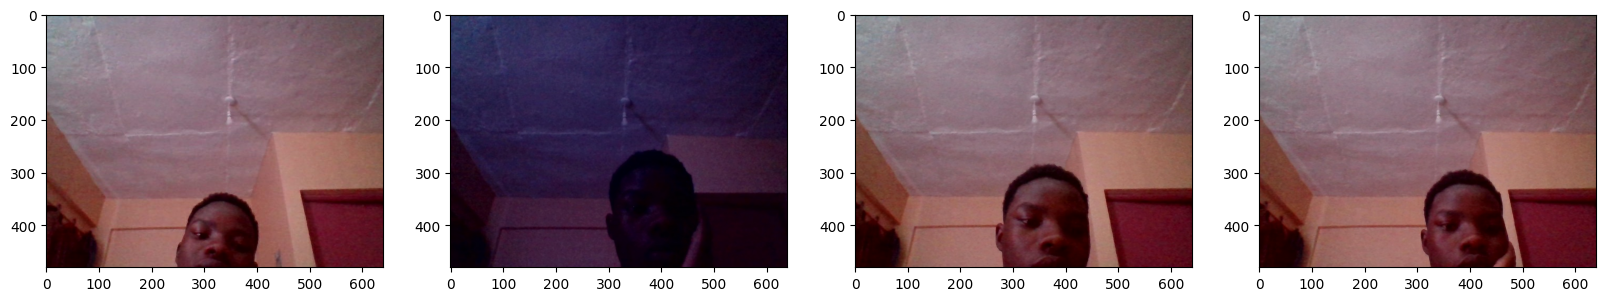

In [22]:
# View images
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

fig, ax =plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()


Partition Unaugmented Data

In [23]:
# move the matching labels
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)



SETUP ALBUMENTATIONS TRANSFORM PIPELINE

In [24]:
import albumentations as alb
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params= alb.BboxParams(format='albumentations',
                                                     label_fields=['class_labels']))

In [25]:
img = cv2.imread(os.path.join('data','train','images','1a7b2367-6b92-11ef-9285-a511a15c1722.jpg'))
img.shape

(480, 640, 3)

In [26]:
#Load images
with open(os.path.join('data','train','labels','1a7b2367-6b92-11ef-9285-a511a15c1722.json'),'r') as f:
    label = json.load(f)

In [27]:
label['shapes'][0]['points']

[[228.02139037433156, 104.43850267379679],
 [390.0534759358288, 311.3903743315508]]

In [28]:
#Extract coordinates and rescale to match image resolution
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[228.02139037433156, 104.43850267379679, 390.0534759358288, 311.3903743315508]

In [29]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.3562834224598931,
 0.21758021390374332,
 0.6094585561497325,
 0.6487299465240641]

APPLY AUGMENTATIONS AND VIEW RESULTS

In [30]:
augmented = augmentor(image=img, bboxes=[coords],class_labels=['face'])
augmented['bboxes']

[(0.2509922756981582,
  0.3457991681521093,
  0.6110635769459298,
  0.8056922162804516)]

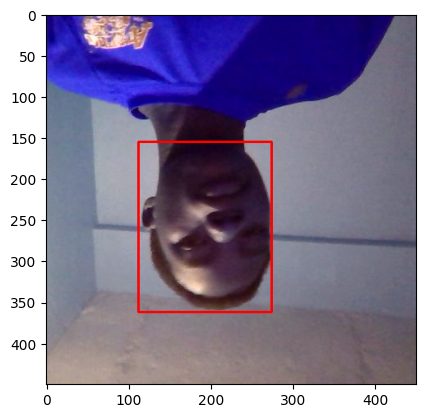

In [31]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
              (255,0,0),2)

plt.imshow(augmented['image'])

BUILD AND RUN AUGMENTATION PIPELINE

In [32]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img = cv2.imread(os.path.join('data',partition,'images',image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data',partition,'labels',f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition, 'images', f'{image.split(".")[0]}.{x}.jpg'),augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0

                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1

                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data',partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.32286096256684493, 0.9974376114081996, 0.051303475935828936, 0.7166889483065954, 'face'].


LOAD AUGMENTED IMAGES TO TENSORFLOW DATASET

In [33]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [34]:
train_images.as_numpy_iterator().next()

array([[[0.46795344, 0.471875  , 0.55177695],
        [0.47273284, 0.4648897 , 0.5487132 ],
        [0.47536764, 0.46213236, 0.54742646],
        ...,
        [0.67156863, 0.74215686, 0.8352941 ],
        [0.66403186, 0.7380515 , 0.8061887 ],
        [0.6709559 , 0.7430147 , 0.79607844]],

       [[0.4759804 , 0.46813726, 0.5541054 ],
        [0.47935048, 0.47150734, 0.56464463],
        [0.50661767, 0.49191177, 0.5884804 ],
        ...,
        [0.6779412 , 0.7480392 , 0.83235294],
        [0.69215685, 0.76139706, 0.8177083 ],
        [0.68541664, 0.752451  , 0.79454654]],

       [[0.49393383, 0.49001226, 0.5606005 ],
        [0.48621324, 0.4822304 , 0.5530025 ],
        [0.46623775, 0.45839462, 0.5407475 ],
        ...,
        [0.67493874, 0.7420343 , 0.8047794 ],
        [0.6780025 , 0.7407476 , 0.7918505 ],
        [0.6983456 , 0.75079656, 0.78903186]],

       ...,

       [[0.5372549 , 0.45588234, 0.46519607],
        [0.5352941 , 0.47267157, 0.47653186],
        [0.56145835, 0

PREPARE LABELS

In [35]:
# BUILD LABEL LOADING FUNCTION
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
    
    class_label = [label['class']]
    bbox_label = label['bbox']
    
    return class_label, bbox_label

def load_labels_wrapper(x):
    class_label, bbox_label = tf.py_function(load_labels, [x], [tf.uint8, tf.float32])
    
    # Explicitly setting the shapes to avoid unknown rank issues
    class_label.set_shape([1])  # Setting shape to a scalar (binary classification output)
    bbox_label.set_shape([4])   # Setting shape for the bounding box (x_min, y_min, x_max, y_max)
    
    return class_label, bbox_label


In [36]:
# LOAD LABELS TO  TENSORFLOW DATASET
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(load_labels_wrapper)

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(load_labels_wrapper)

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(load_labels_wrapper)




COMBINE LABEL AND IMAGE SAMPLES

In [37]:
#check partition lengths 
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4200, 4200, 840, 840, 900, 900)

In [38]:
# Create final dataset(images/labels)
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [39]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.4111824 , 0.32192513, 0.74273324, 0.77231133],
        [0.6768984 , 0.4150921 , 1.        , 0.90588236],
        [0.19136067, 0.17390375, 0.55618536, 0.6135948 ],
        [0.83997625, 0.579798  , 1.        , 0.9075787 ],
        [0.29730242, 0.21208556, 0.64667857, 0.67079026],
        [0.        , 0.        , 0.        , 0.        ],
        [0.35492572, 0.23414141, 0.7054902 , 0.6833393 ],
        [0.17548425, 0.3516934 , 0.5165419 , 0.86149734]], dtype=float32))

VIEW IMAGES AND ANNOTATIONS

In [40]:
data_samples = train.as_numpy_iterator()

In [41]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


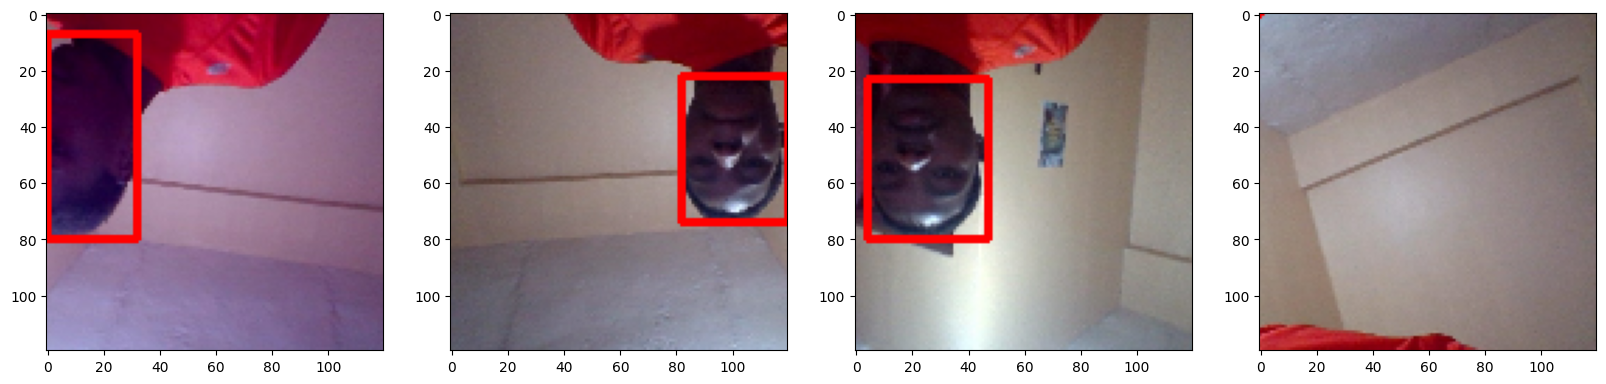

In [42]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = np.copy(res[0][idx])
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0),2
                  )
    ax[idx].imshow(sample_image)

BUILD A DEEP LEARNING USING FUNCTIONAL API

In [43]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D,Dense, GlobalMaxPooling2D, Dropout
from tensorflow.keras.applications import VGG16

In [45]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

BUILD INSTANCE OF NETWORK

In [46]:

def build_model():
    input_layer = Input(shape=(120, 120, 3))
    
    # Load the pre-trained VGG16 model without the top layers
    vgg = VGG16(include_top=False)(input_layer)

    # Classification model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class1 = Dropout(0.5)(class1)  # Dropout layer to prevent overfitting
    class2 = Dense(1, activation='sigmoid')(class1)

    # Regression bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress1 = Dropout(0.5)(regress1)  # Dropout layer to prevent overfitting
    regress2 = Dense(4, activation='sigmoid')(regress1)

    # Combine both classification and regression models
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    
    return facetracker


TEST AOUT NEURAL NETWORK

In [47]:
facetracker = build_model()
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
X,y = train.as_numpy_iterator().next()

In [49]:
X.shape

(8, 120, 120, 3)

In [50]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(array([[0.3852448 ],
        [0.36332998],
        [0.35138664],
        [0.35728696],
        [0.40153918],
        [0.39356947],
        [0.4555463 ],
        [0.32203943]], dtype=float32),
 array([[0.5044394 , 0.73359805, 0.4875567 , 0.48333517],
        [0.5851706 , 0.6341066 , 0.5289994 , 0.5452081 ],
        [0.51388466, 0.65249944, 0.38175878, 0.48728302],
        [0.45335144, 0.6960721 , 0.5374797 , 0.47955686],
        [0.5737237 , 0.6681311 , 0.49660397, 0.52258444],
        [0.53491175, 0.66930735, 0.36761183, 0.48951435],
        [0.5361221 , 0.65049154, 0.5733136 , 0.5291003 ],
        [0.5154071 , 0.65639603, 0.3679011 , 0.5285348 ]], dtype=float32))

DIFINE LOSSES AND OPTIMIZERS

In [51]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [52]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [53]:
# create localization loss and classification loss
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [54]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [55]:
# test out loss metrics
localization_loss(y[1],coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.729085>

In [56]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9534257>

In [57]:
print(y[0].shape)  # Should be (batch_size, 1)
print(y[1].shape)  # Should be (batch_size, 4)


(8, 1)
(8, 4)


In [58]:
print(y[1].shape)
print(classes.shape)


(8, 4)
(8, 1)


In [59]:
print("y[0] shape (classification labels):", tf.shape(y[0]))
print("y[1] shape (bounding box labels):", tf.shape(y[1]))
print("classes shape (predicted classes):", tf.shape(classes))
print("coords shape (predicted bounding boxes):", tf.shape(coords))


y[0] shape (classification labels): tf.Tensor([8 1], shape=(2,), dtype=int32)
y[1] shape (bounding box labels): tf.Tensor([8 4], shape=(2,), dtype=int32)
classes shape (predicted classes): tf.Tensor([8 1], shape=(2,), dtype=int32)
coords shape (predicted bounding boxes): tf.Tensor([8 4], shape=(2,), dtype=int32)


TRAIN NEURAL NETWORK

In [60]:
# Create custom model
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        X, y = batch
        
        with tf.GradientTape() as tape: 
            # Forward pass
            classes, coords = self.model(X, training=True)
            
            # Debugging: Print shapes to ensure they match
            print(f"y[0] shape: {y[0].shape}, classes shape: {classes.shape}")
            print(f"y[1] shape: {y[1].shape}, coords shape: {coords.shape}")
            
            # Ensure y[0] and classes are of the same shape and type
            y_true_class = tf.reshape(tf.cast(y[0], tf.float32), [-1])
            y_pred_class = tf.reshape(tf.cast(classes, tf.float32), [-1])
            
            # Ensure y[1] and coords are of the same shape and type
            y_true_coords = tf.cast(y[1], tf.float32)
            
            # Compute the classification and regression losses
            batch_classloss = self.closs(y_true_class, y_pred_class)
            batch_localizationloss = self.lloss(y_true_coords, coords)
            
            # Compute total loss
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            
            # Compute gradients and apply them
            grad = tape.gradient(total_loss, self.model.trainable_variables)
            self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)


In [61]:
model = FaceTracker(facetracker)

model.compile(opt, classloss, regressloss)

TRAIN

In [62]:
logdir = 'logs'

In [63]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [64]:
for batch in train.take(1):
    X, y = batch
    class_labels, bbox_labels = y
    classes, coords = model(X)

    print("class_labels shape:", class_labels.shape)
    print("bbox_labels shape:", bbox_labels.shape)
    print("classes (predicted) shape:", classes.shape)
    print("coords (predicted) shape:", coords.shape)


class_labels shape: (8, 1)
bbox_labels shape: (8, 4)
classes (predicted) shape: (8, 1)
coords (predicted) shape: (8, 4)


In [65]:
hist = model.fit(train, epochs=1, validation_data=val, callbacks=[tensorboard_callback])


y[0] shape: (None, 1), classes shape: (None, 1)
y[1] shape: (None, 4), coords shape: (None, 4)
y[0] shape: (None, 1), classes shape: (None, 1)
y[1] shape: (None, 4), coords shape: (None, 4)
525/525 ━━━━━━━━━━━━━━━━━━━━ 1159s 2s/step - class_loss: 0.1334 - regress_loss: 0.5115 - total_loss: 0.5782 - val_class_loss: 0.0032 - val_regress_loss: 0.0816 - val_total_loss: 0.0832


PLOT PERFORMANCE

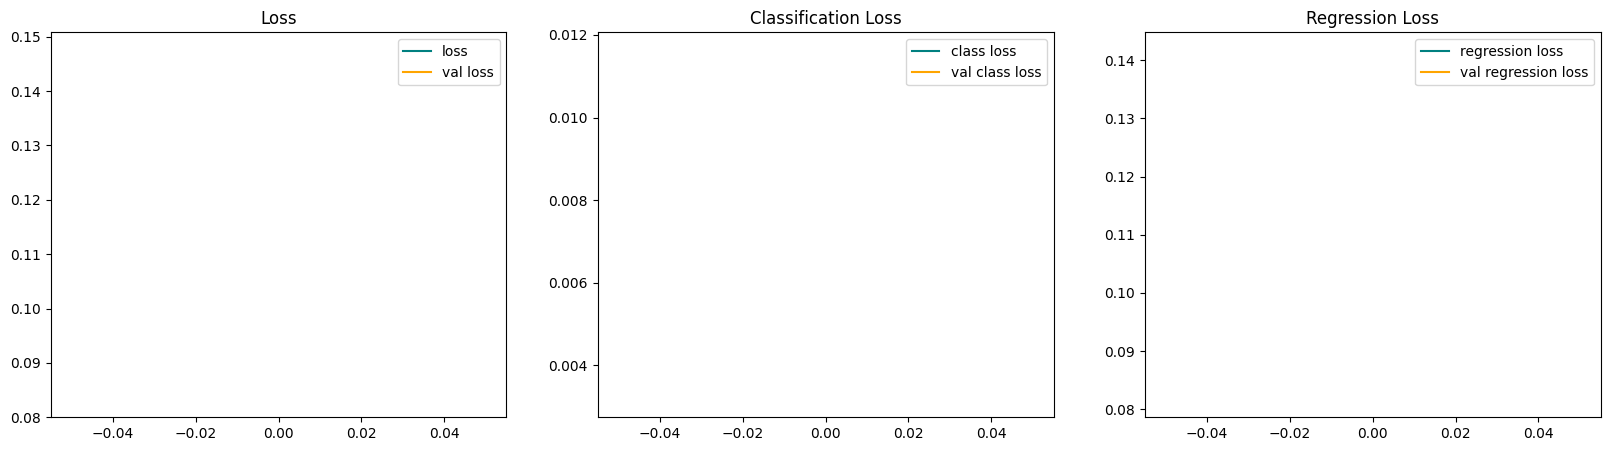

In [66]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange',label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange',label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regression loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange',label='val regression loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

TESTING THE MODEL

In [67]:
test_data = test.as_numpy_iterator()

In [68]:
test_sample = test_data.next()

In [69]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


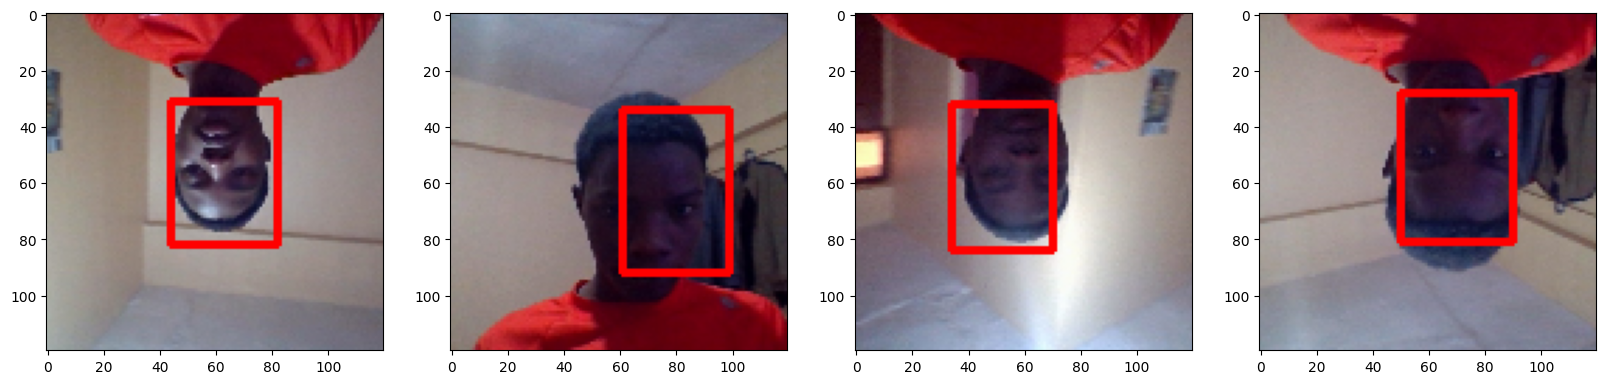

In [70]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = np.copy(test_sample[0][idx])
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)



SAVE THE MODEL

In [71]:
from tensorflow.keras.models import load_model

In [72]:
facetracker.save('facetracker.h5')

REAL TIME DETECTION

In [76]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
                    
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 